I get from part 1 a list of points and to what object they belong
Ex of points:

In [151]:
import matplotlib.pyplot as plt
import random

def generate_random_points(num_points):
    random_points = []
    for _ in range(num_points):
        x = random.uniform(-10, 10)  # Change the range (-10, 10) as desired
        y = random.uniform(-10, 10)  # Change the range (-10, 10) as desired
        random_points.append((x, y))
    return random_points

############################################################################################################
#function that checks if two line segments intersect

#function that defines the orientation of three given points
def compute_orientation(p1,p2,p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    orientation_value = (y2-y1)*(x3-x2)-(y3-y2)*(x2-x1)
    # Check for collinear, clockwise, or counterclockwise orientation
    if orientation_value == 0:
        return 0  # Collinear
    elif orientation_value > 0:
        return -1  # Clockwise orientation
    else:
        return 1  # Counterclockwise orientation

#For 3 collinear points a,b,c, we search if point c lies on segment ab    
def onSegment(a, b, c): 
    xa, ya = a
    xb, yb = b
    xc, yc = c
    if ( (xc <= max(xa, xb)) and (xc >= min(xa, yb)) and 
           (yc <= max(ya, yb)) and (yc >= min(ya, yb))): 
        return True
    return False

#function that checks if two line segments intersect
def intersect(p1,q1,p2,q2):
    xp1, yp1 = p1
    xq1, yq1 = q1
    xp2, yp2 = p2
    xq2, yq2 = p2

    o1=compute_orientation(p1,q1,p2)
    o2=compute_orientation(p1,q1,q2)
    o3=compute_orientation(p2,q2,p1)
    o4=compute_orientation(p2,q2,q1)

    # General case
    if o1 != o2 and o3 != o4:
        return True
    
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, q1, p2)): 
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q1, q2)): 
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, q2, p1)): 
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q2, q1)): 
        return True
    
    return False 
############################################################################################################

#function that generates random objects    
def generate_pts_object():
    points = []
    num_points = random.randint(3, 5)  # Random number of points for each object between 3 and 8
    while len(points) < num_points:
        # Add a random point to the list of points
        point = (random.uniform(-10, 10), random.uniform(-10, 10))
        points.append(point)

        # Check for intersection with the previous segments in the list
        if len(points) >= 4:
            for j in range(len(points)-3):
                if intersect(points[len(points)-1], points[len(points)-2], points[j], points[j+1]) or intersect(points[0], points[len(points)-1], points[j+1], points[j+2]):
                    points.pop()  # Remove the last point if it intersects
                    break
            
    return points

def generate_all_objects(object_edges, min_objects, max_objects):
    num_objects = random.randint(min_objects, max_objects)

    for i in range(num_objects):
        intersects = True
        while intersects:
            intersects = False
            points = generate_pts_object()

            # Check if the current object intersects with any of the previous objects
            for j in range(i):
                for k in range(len(points) - 1):
                    for l in range(len(object_edges[f"Object_{j}"]) - 1):
                        if intersect(points[k], points[k + 1], object_edges[f"Object_{j}"][l],
                                     object_edges[f"Object_{j}"][l + 1]):
                            intersects = True
                            break
                    if intersects:
                        break
                if intersects:
                    break

            if not intersects:
                object_edges[f"Object_{i}"] = points
                break  # Break out of the while loop once a non-intersecting object is found

    return object_edges

def point_in_polygon(point, polygon):
    n = len(polygon)
    inside = False

    x, y = point
    for i in range(n):
        j = (i + 1) % n
        xi, yi = polygon[i]
        xj, yj = polygon[j]

        intersect = ((yi > y) != (yj > y)) and (x < (xj - xi) * (y - yi) / (yj - yi) + xi)
        if intersect:
            inside = not inside

    return inside

def generate_random_point_not_in_polygons(object_edges):
    while True:
        # Generate a random point within a range (adjust range as needed)
        random_point = (random.uniform(-10, 10), random.uniform(-10, 10))

        # Check if the random point is inside any polygon
        inside_polygon = False
        for polygon_points in object_edges.values():
            if point_in_polygon(random_point, polygon_points):
                inside_polygon = True
                break

        if not inside_polygon:
            return random_point

points=generate_pts_object()
print(points)

# Generate random objects with random points and add them to the object_edges dictionary
object_edges = {}

object_edges = generate_all_objects(object_edges,min_objects=2, max_objects=2)

SandG = {
"start" : generate_random_point_not_in_polygons(object_edges),
"goal" : generate_random_point_not_in_polygons(object_edges)
}

# Display the generated random objects
print("Generated Random Objects:")
for obj_id, points in object_edges.items():
    print(f"{obj_id}: {points}")
for obj_id, points in SandG.items():
    print(f"{obj_id}: {points}")


[(-4.858136148207288, 5.271325342639734), (-6.113152941729744, 4.2284941104038545), (-1.57181094507607, -9.351635124631803)]
Generated Random Objects:
Object_0: [(-7.542307497655212, -7.8356118999948166), (-8.187563099970387, -9.816713762127481), (-2.1101101343175, 4.94444248160281), (-5.6718037333813065, 3.682096383873972), (-8.362449403938012, -0.5332267159044015)]
Object_1: [(9.268521103615779, -0.9806576901452395), (7.655094946165772, -0.869452257635956), (8.526347950623709, -9.443190006413268), (9.252411509075515, -4.287145085113069)]
start: (-8.222440217735159, -4.578071731232991)
goal: (1.0426539395272254, -5.355469682315581)


In [152]:

#############################################################################################################
#From the list of point I need to establish which points are connected to each other.
#The points are connected if they don't cross a line connecting points from the same object.

#function that defines the orientation of three given points
def compute_orientation(p1,p2,p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    orientation_value = (y2-y1)*(x3-x2)-(y3-y2)*(x2-x1)
    # Check for collinear, clockwise, or counterclockwise orientation
    if orientation_value == 0:
        return 0  # Collinear
    elif orientation_value > 0:
        return -1  # Clockwise orientation
    else:
        return 1  # Counterclockwise orientation

#For 3 collinear points a,b,c, we search if point c lies on segment ab    
def onSegment(a, b, c): 
    xa, ya = a
    xb, yb = b
    xc, yc = c
    if ( (xc <= max(xa, xb)) and (xc >= min(xa, yb)) and 
           (yc <= max(ya, yb)) and (yc >= min(ya, yb))): 
        return True
    return False

#function that checks if two line segments intersect
def intersect(p1,q1,p2,q2):
    xp1, yp1 = p1
    xq1, yq1 = q1
    xp2, yp2 = p2
    xq2, yq2 = p2

    o1=compute_orientation(p1,q1,p2)
    o2=compute_orientation(p1,q1,q2)
    o3=compute_orientation(p2,q2,p1)
    o4=compute_orientation(p2,q2,q1)
    #If two points are equal 
    if p1==p2 or p1==q2 or q1==p2 or q1==q2:
        return False
    
    # General case
    if o1 != o2 and o3 != o4:
        return True
    
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, q1, p2)): 
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q1, q2)): 
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, q2, p1)): 
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q2, q1)): 
        return True
    return False 

Test function intersection: 

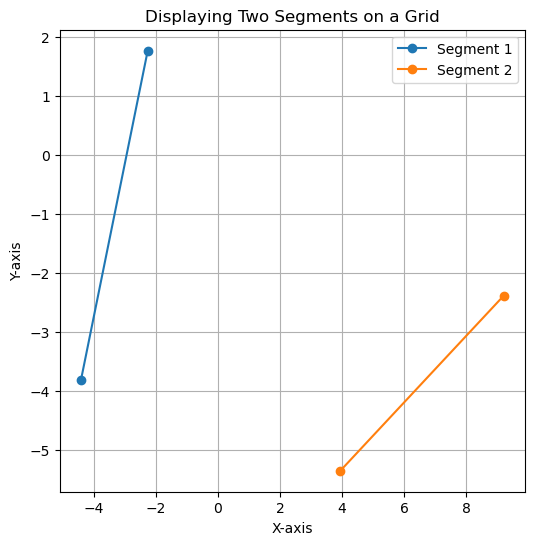

Are the segments crossing?  False


In [153]:
import matplotlib.pyplot as plt
import random


def display_segments(p1, p2, p3, p4):

    # Extracting coordinates for the segments
    x_values_segment1 = [p1[0], p2[0]]
    y_values_segment1 = [p1[1], p2[1]]

    x_values_segment2 = [p3[0], p4[0]]
    y_values_segment2 = [p3[1], p4[1]]

    # Create a plot
    plt.figure(figsize=(6, 6))

    # Plotting the segments
    plt.plot(x_values_segment1, y_values_segment1, label='Segment 1', marker='o')
    plt.plot(x_values_segment2, y_values_segment2, label='Segment 2', marker='o')

    # Set plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Displaying Two Segments on a Grid')

    # Add legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()

# Example points represented by tuples (x, y)
point1 = (random.uniform(-10, 10), random.uniform(-10, 10))
point2 = (random.uniform(-10, 10), random.uniform(-10, 10))
point3 = (random.uniform(-10, 10), random.uniform(-10, 10))
point4 = (random.uniform(-10, 10), random.uniform(-10, 10))

# Display the segments based on the given points
display_segments(point1, point2, point3, point4)

print("Are the segments crossing? ",intersect (point1,point2,point3,point4))

In [154]:
def assign_name(object_edges, GandS):
    point_names = {}  # Dictionary to map points to unique names
    j = 0

    for obj_id, points_list in object_edges.items():
        for point in points_list:
            point_names[f'P{j}'] = point
            j += 1
    point_names['S']=GandS['start']
    point_names['G']=GandS['goal']
    return point_names

def pts_in_objects(object_edges):
    point_names = {}  # Dictionary to map points to unique names
    j = 0  # Starting point index

    for obj_id, points_list in object_edges.items():
        point_names[obj_id] = []  # Initialize a list to store point names for each object
        for _ in points_list:
            point_names[obj_id].append(f'P{j}')  # Append individual point names to the list
            j += 1

    return point_names


point_names = assign_name(object_edges, SandG)
point_objects = pts_in_objects(object_edges)
for obj_id, points in point_names.items():
    print(f"{obj_id}: {points}")

for obj_id, points in point_objects.items():
    print(f"{obj_id}: {points}")

P0: (-7.542307497655212, -7.8356118999948166)
P1: (-8.187563099970387, -9.816713762127481)
P2: (-2.1101101343175, 4.94444248160281)
P3: (-5.6718037333813065, 3.682096383873972)
P4: (-8.362449403938012, -0.5332267159044015)
P5: (9.268521103615779, -0.9806576901452395)
P6: (7.655094946165772, -0.869452257635956)
P7: (8.526347950623709, -9.443190006413268)
P8: (9.252411509075515, -4.287145085113069)
S: (-8.222440217735159, -4.578071731232991)
G: (1.0426539395272254, -5.355469682315581)
Object_0: ['P0', 'P1', 'P2', 'P3', 'P4']
Object_1: ['P5', 'P6', 'P7', 'P8']


P0
P1
P2
P3
P4
P5
P6
P7
P8


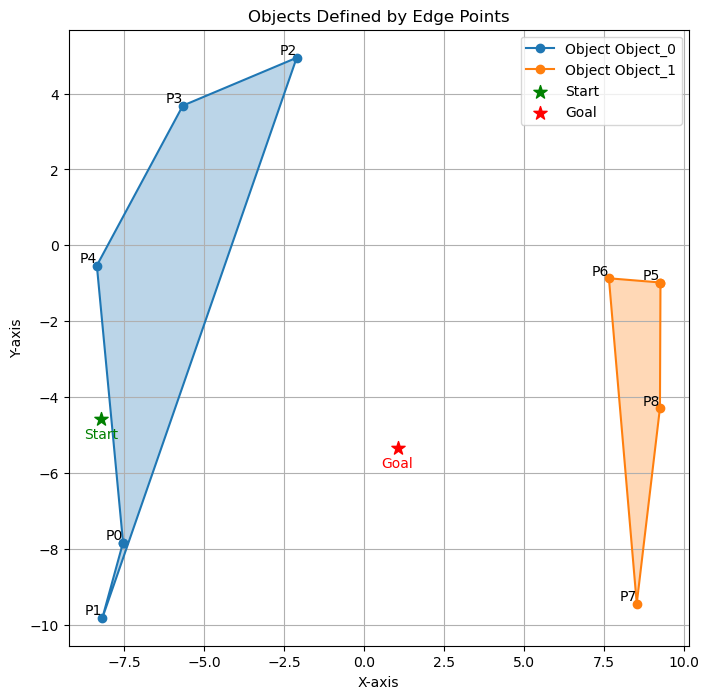

In [158]:
import matplotlib.pyplot as plt
import copy

def plot_objects(object_edges, GandS):
    object_edges_copy = copy.deepcopy(object_edges)
    point_names = assign_name(object_edges_copy, SandG)
    plt.figure(figsize=(8, 8))
    
    coordinate_to_name = {v: k for k, v in point_names.items()}
    for obj_id, points in object_edges_copy.items():
        if isinstance(points, list):
            # Edge points: List of tuples
            x_values = [point[0] for point in points]
            y_values = [point[1] for point in points]

            # Check if the first and last points are the same to close the shape
            if points[0] != points[-1]:
                points.append(points[0])  # Append the first point at the end to close the shape

            # Update x and y values after closing the shape
            x_values = [point[0] for point in points]
            y_values = [point[1] for point in points]

            # Plot the points representing the edges of the object
            plt.plot(x_values, y_values, label=f'Object {obj_id}', marker='o')

            # Fill the shape defined by the points for each object
            plt.fill(x_values, y_values, alpha=0.3)

            # Label each point on the plot with its assigned name (Pi)
            for i in range(0, len(points)-1):
                plt.text(points[i][0], points[i][1], coordinate_to_name[points[i]], color='black', ha='right', va='bottom')
                print(coordinate_to_name[points[i]])

    # Plot the Start and Goal points
    plt.scatter(point_names['S'][0], point_names['S'][1], color='green', label='Start', s=100, marker='*', zorder=3)
    plt.text(point_names['S'][0], point_names['S'][1] - 0.5, 'Start', color='green', ha='center')

    plt.scatter(point_names['G'][0], point_names['G'][1], color='red', label='Goal', s=100, marker='*', zorder=3)
    plt.text(point_names['G'][0], point_names['G'][1] - 0.5, 'Goal', color='red', ha='center')

    # Set plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Objects Defined by Edge Points')

    # Add legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()


plot_objects(object_edges, SandG)

In [ ]:
pip install shapely


Note: you may need to restart the kernel to use updated packages.


In [184]:
def is_connected(point1, point2, object_edges):
    point_names = assign_name(object_edges, SandG)
    coordinate_to_name = {v: k for k, v in point_names.items()}
    point_objects = pts_in_objects(object_edges)

    #if point1 and point2 are in same object but not adjacent return  false
    P1= coordinate_to_name[point1] #P1 is the name of the point1
    P2= coordinate_to_name[point2] #P2 is the name of the point2
    for object, points in point_objects.items():
        if P1 in points and P2 in points:
            if abs(points.index(P1)-points.index(P2))!=1:
                return False
            if points.index(P1)==len(points)-1 and points.index(P2)!=0:
                return False
            if points.index(P2)==len(points)-1 and points.index(P1)!=0:
                return False
    
    #We go through all abject and check if the line between point1 and point2 
    #intersect with any of the vertices of an object
    for object, points in object_edges.items():
        for j in range(len(points) - 1):
            if j == (len(points) - 1):
                if intersect(point1, point2, points[j], points[0]):
                    print("intersection between ", coordinate_to_name[point1], coordinate_to_name[point2], "and", coordinate_to_name[points[j]], coordinate_to_name[points[0]])
                    return False
            else:
                if points[j] == point1 or points[j+1] == point2:
                    continue
                    
                else:
                    if intersect(point1, point2, points[j], points[j + 1]):
                        print("intersection between ", coordinate_to_name[point1], coordinate_to_name[point2], "and", coordinate_to_name[points[j]], coordinate_to_name[points[j + 1]])
                        return False
            print("no intersection between ", coordinate_to_name[point1], coordinate_to_name[point2], "and", coordinate_to_name[points[j]], coordinate_to_name[points[j + 1]])
    return True


print("is connected: " ,is_connected(point_names['P8'], point_names['P6'], object_edges))

is connected:  False


In [ ]:
links_map = {
    'a':1,
    'b':2
}
print(len(links_map))

2
